# Actor Critic Method and Modified Actor Critic Method with Reward Shaping
Unfortunately, either of the methods failed to reach the goal. But there is still something to learn from these two models. The car chooses to stay still instead of exploring to get a very high reward but with action penalty.

**Mountain Car MDP**


The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reinforce

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

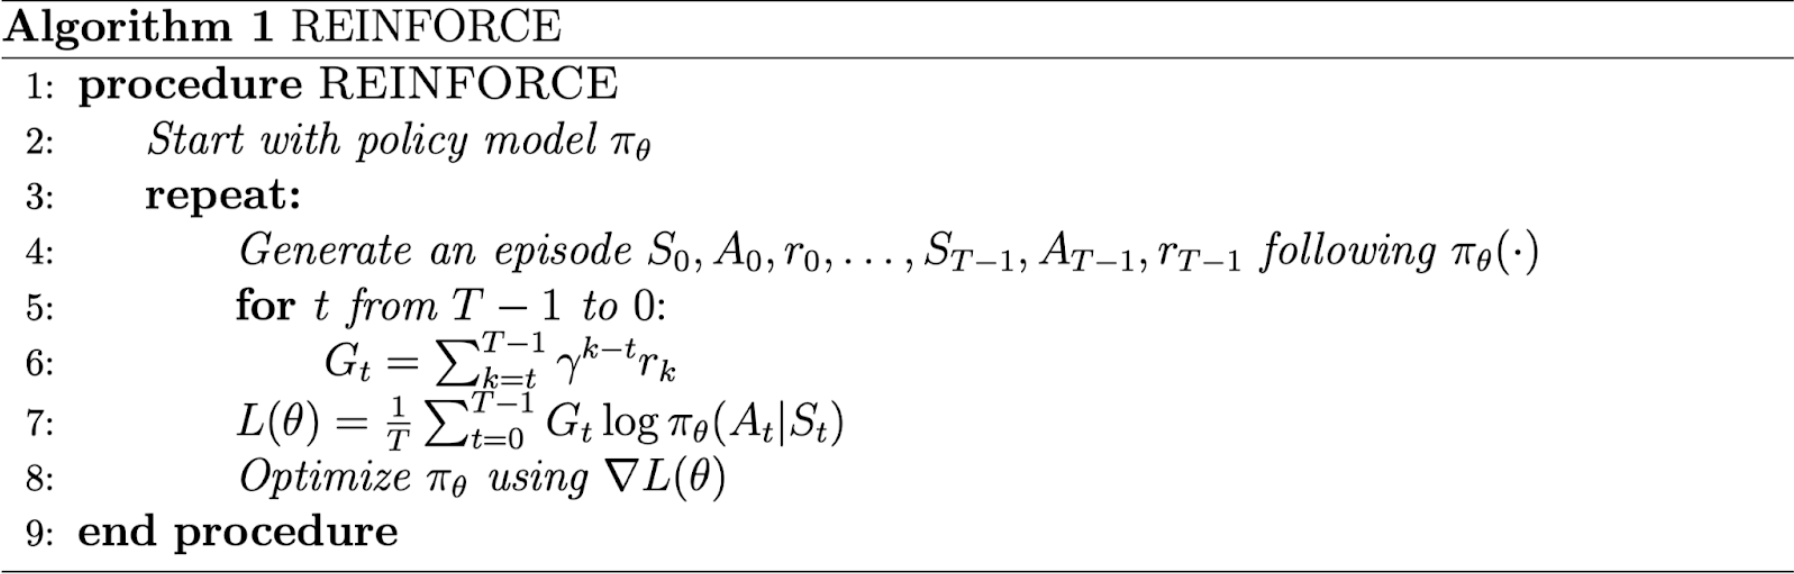




### Hints
- Try to use at least a 3 to 4 layer network with tanh activation at last layer.
- Use high value of gamma and max_steps
- Try to understand the reward function and think how the agent can get stuck in a non-optimal reward trajectory.

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cpu')

In [ ]:
# Create the environment
env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Policy Network

In [ ]:
class ActorCritic(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.affine1 = nn.Linear(n_observations, 128)
        self.affine2 = nn.Linear(128, 128)
        self.affine3 = nn.Linear(128, 256)
        self.affine4 = nn.Linear(256, 256)

        # actor's layer
        self.action_head = nn.Linear(256, n_actions + 1)

        # critic's layer
        self.value_head = nn.Linear(256, 1)

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        x2 = F.relu(self.affine2(x))
        x3 = F.relu(self.affine3(x2))
        x4 = F.relu(self.affine4(x3))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.tanh(self.action_head(x4))

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x4)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, state_value = self.forward(state)
        # create a categorical distribution over the list of probabilities of actions
        m = Normal(probs[0][0], abs(probs[0][1]))
        # and sample an action using the distribution
        action = m.sample()
        return action.item(), m.log_prob(action), state_value.squeeze(0)

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 1000        # Total training episodes
max_steps = 1000              # Max steps per episode
learning_rate = 1e-2         # Learning rate
gamma = 0.999                 # Discounting rate

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1


In [ ]:
# Intialize policy network
actor_critic = ActorCritic(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

In [ ]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  saved_buffer = {'log_prob':[], 'value':[]}
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = actor_critic.act(state)
    action = [action]
    # print(action)
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    saved_buffer["log_prob"].append(log_prob)
    saved_buffer["value"].append(value)
    if done:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_losses = [] # list to save actor (policy) loss
  value_losses = [] # list to save critic (value) loss

  for log_prob, value, R in zip(saved_buffer["log_prob"], saved_buffer["value"], returns):
    advantage = R - value.item()

    # calculate actor (policy) loss
    policy_losses.append(-log_prob * advantage)

    # calculate critic (value) loss using L1 smooth loss
    value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

  # sum up all the values of policy_losses and value_losses
  loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

  # Back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = -0.35051343254886425
Episode 2: Reward = -86.28255095152029
Episode 3: Reward = -159.93609734798633
Episode 4: Reward = -163.1444589624526
Episode 5: Reward = -138.00055881317664
Episode 6: Reward = -81.85185854193386
Episode 7: Reward = -29.94007135975934
Episode 8: Reward = -4.742128323772448
Episode 9: Reward = -4.089036581541599
Episode 10: Reward = -11.505799507129439
Episode 11: Reward = -14.788325591605345
Episode 12: Reward = -7.059984612678409
Episode 13: Reward = -5.746643697305935
Episode 14: Reward = -7.766197113422462
Episode 15: Reward = -5.562167587038466
Episode 16: Reward = -4.011171850313746
Episode 17: Reward = -2.8373316270945073
Episode 18: Reward = -1.9901846251887323
Episode 19: Reward = -1.3727560311985618
Episode 20: Reward = -1.0137062413656486
Episode 21: Reward = -0.8478075052465163
Episode 22: Reward = -0.7494250392893136
Episode 23: Reward = -0.6360246301942751
Episode 24: Reward = -0.5698689550223162
Episode 25: Reward = -0.70075783398

Text(0, 0.5, 'Reward')

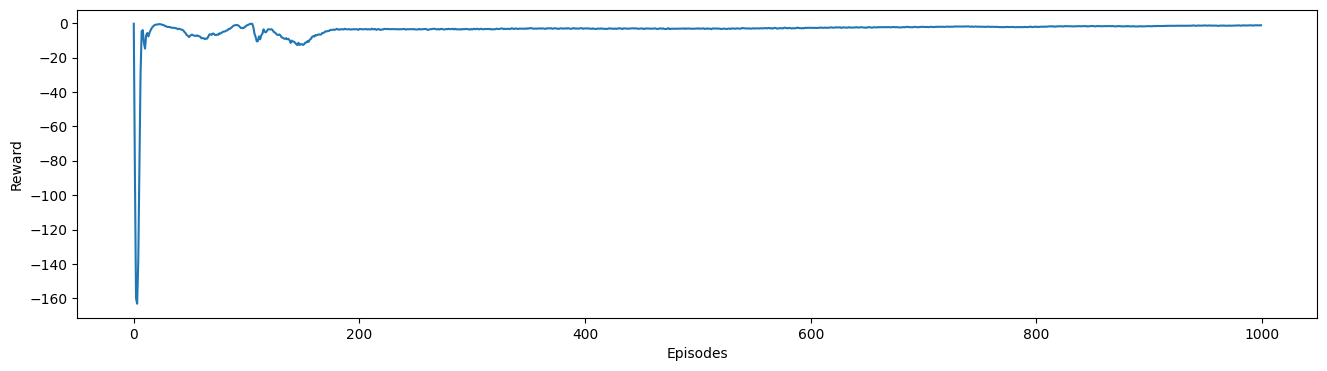

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _, _ = actor_critic.act(state)
        action = [action]
        next_state, reward, done, info = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
show_video_of_model("MountainCarContinuous-v0")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializati

In [ ]:
show_video("MountainCarContinuous-v0")

# Reward Shaping Method

In [ ]:
def get_height(x_pos):
  return np.sin(x_pos * 3) * 0.45 + 0.55

In [ ]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  new_rewards = []
  saved_buffer = {'log_prob':[], 'value':[]}
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    old_state = state
    action, log_prob, value = actor_critic.act(state)
    action = [action]
    state, reward, done, _ = env.step(action)

    if reward > 0 :
      print("Successfully get to the target!!!")

    old_pos = old_state[0]
    old_v = old_state[1]
    new_pos = state[0]
    new_v = state[1]
    old_height = get_height(old_pos)
    new_height = get_height(new_pos)

    new_reward = 10*(2 * new_height + new_v * new_v)

    new_rewards.append(new_reward)
    saved_buffer["log_prob"].append(log_prob)
    saved_buffer["value"].append(value)
    if done:
        break

  scores.append(sum(new_rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(new_rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + new_rewards[t]   )

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_losses = [] # list to save actor (policy) loss
  value_losses = [] # list to save critic (value) loss

  for log_prob, value, R in zip(saved_buffer["log_prob"], saved_buffer["value"], returns):
    advantage = R - value.item()

    # calculate actor (policy) loss
    policy_losses.append(-log_prob * advantage)

    # calculate critic (value) loss using L1 smooth loss
    value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

  # sum up all the values of policy_losses and value_losses
  loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

  # Back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = 2032.5362672424355
Episode 2: Reward = 2022.8282074757183
Episode 3: Reward = 2055.0576939873504
Episode 4: Reward = 2383.0683572903745
Episode 5: Reward = 2293.774191108925
Episode 6: Reward = 2305.062291020814
Episode 7: Reward = 2052.0664898543087
Episode 8: Reward = 2153.4052379073432
Episode 9: Reward = 2013.8446882423286
Episode 10: Reward = 2348.5197908350756
Episode 11: Reward = 2046.1538529661957
Episode 12: Reward = 2237.39919773361
Episode 13: Reward = 2046.9130319071708
Episode 14: Reward = 2099.120246054654
Episode 15: Reward = 2240.2107449072996
Episode 16: Reward = 2029.7899989647901
Episode 17: Reward = 2046.37501530958
Episode 18: Reward = 2092.1238974307735
Episode 19: Reward = 2016.8530385780568
Episode 20: Reward = 2118.736483463791
Episode 21: Reward = 2028.8669404281875
Episode 22: Reward = 2018.9754455092877
Episode 23: Reward = 2021.0741061859599
Episode 24: Reward = 2015.116415521778
Episode 25: Reward = 2090.5557934130074
Episode 26: Reward

Text(0, 0.5, 'Reward')

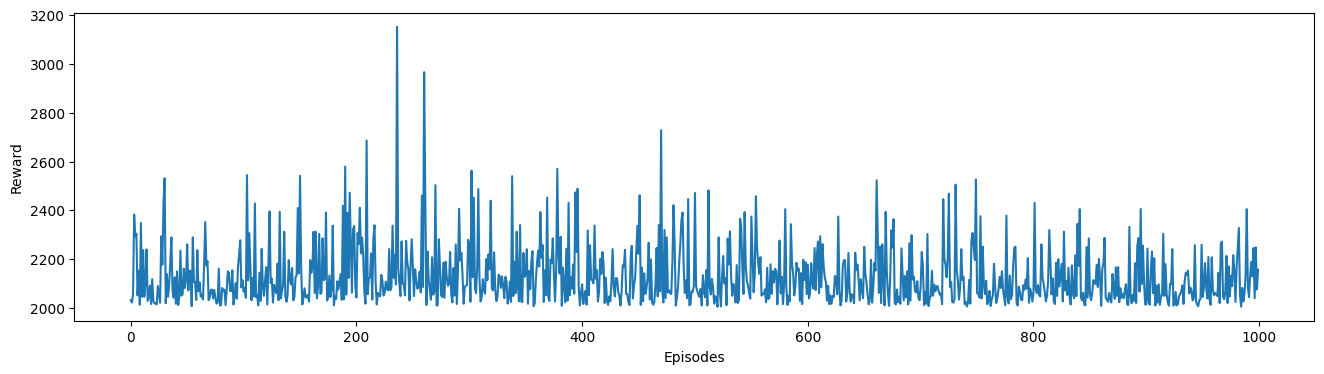

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _, _ = actor_critic.act(state)
        action = [action]
        next_state, reward, done, info = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("MountainCarContinuous-v0")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializati

In [ ]:
show_video("MountainCarContinuous-v0")